In [1]:
import torch
import glob 
# from google.colab import drive
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
from torch import nn
from skimage.transform import resize
import segmentation_models_pytorch as smp
from sklearn.metrics import jaccard_score
from torchvision.transforms import transforms
import pydicom
import cv2
import plotly.graph_objects as go
import plotly.express as px
from scipy.signal import find_peaks

In [2]:
def guess_color_space(img):
    # Calculate the mean and standard deviation of each channel
    means = np.mean(img, axis=(0,1))
    std_devs = np.std(img, axis=(0,1))

    # If the first channel has significantly different characteristics than the other two
    # it might hint towards YCbCr. This is just a heuristic.
    if abs(means[0] - np.mean(means[1:])) > 30 and abs(std_devs[0] - np.mean(std_devs[1:])) > 30:
        return 'YCbCr'
    else:
        return 'RGB'

In [10]:
paths = glob.glob(os.path.join('d:/University/1-Calgary/experiments/1 - reading images/images/', '*' ))
dcms = [pydicom.dcmread(path) for path in paths]
images = [dcm.pixel_array for dcm in dcms]

In [64]:
items = [item for item in dcms[0].items()]

In [65]:
for dcm in dcms:
    print(dcm.file_meta.TransferSyntaxUID)

1.2.840.10008.1.2.4.50
1.2.840.10008.1.2.4.50
1.2.840.10008.1.2.4.50
1.2.840.10008.1.2.5
1.2.840.10008.1.2
1.2.840.10008.1.2.4.50
1.2.840.10008.1.2


In [86]:
img = images[-3][-1,:,:,:]
hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Define the range for the green color
lower_green = np.array([40, 40, 40])
upper_green = np.array([80, 255, 255])

# Create a mask for the green color
mask = cv2.inRange(hsv_image, lower_green, upper_green)

# Set non-green pixels to 0 and green pixels to a specific value
filtered_image = cv2.bitwise_and(img, img, mask=mask)

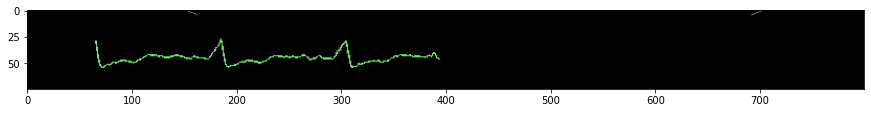

In [87]:
# input = dcms[48].pixel_array[-1,:,:,:]
plt.figure(figsize=(15,15))
s = int(filtered_image.shape[0]*7/8)
plt.imshow(filtered_image[s:, :,:])

In [2]:
def plotly_visualization(x, y, title=''):
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=y, mode='lines', name='ECG'))
    fig.add_trace(go.Scatter(x=x, y=y[x], mode='markers', marker=dict(symbol='x', size=8, color='red'), name='R-peaks'))

    fig_width = 800 
    fig_height = 400  
    fig.update_layout(
        title=title,
        yaxis= dict(autorange='reversed'),
        width=fig_width,
        height=fig_height
    )

    fig.show()

In [3]:
def img_visualization(image, title='', color=''):
    if color=='gray':
        fig = px.imshow(image, color_continuous_scale='gray')
    else:
        fig = px.imshow(image)
    fig.update_layout(
        title=title,
        width=800,
        height=200,
        coloraxis_showscale=False
    )
    fig.show()

In [4]:
def green_line_extractor(image, color_map):
   
   # if color_map == 'YCbCr':
   image = cv2.cvtColor(image, cv2.COLOR_YCrCb2RGB)

    # converting to hsv
   hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

   # Define the range for the green color
   lower_green = np.array([40, 40, 40])
   upper_green = np.array([80, 255, 255])

   # Create a mask for the green color
   mask = cv2.inRange(hsv_image, lower_green, upper_green)

   # Set non-green pixels to 0 and green pixels to a specific value
   # filtered_image = cv2.bitwise_and(image, image, mask=mask)

   return mask

In [19]:
s= np.array([0,2,3,4])
np.arange(s.shape[0])

array([0, 1, 2, 3])

In [30]:
def detect_peaks(y_coordinates):
    # Detect R-peaks

    peaks = list()
    # last_non_none = next((item for item in reversed(y_coordinates) if item is not None), None)
    y_coordinates_non_none = y_coordinates[y_coordinates != None] 

    threshold_value =  -int((y_coordinates_non_none.min() + y_coordinates_non_none.max())/2)
    # assigning a high value that doesn't affect peaks as find_peaks() input shouldn't have none vals
    y_coordinates[y_coordinates == None] = 1000


    xrange_ECG = np.where(y_coordinates!=1000)[0]
    print(f'xrange {xrange_ECG}')
    x_distance = int((xrange_ECG[-1] - xrange_ECG[0])/3)
    print(x_distance)
    x_peaks, _ = find_peaks(-y_coordinates, distance=x_distance)
    # threshold to filter out peaks below a certain amplitude
    x_peaks = [x for x in x_peaks if -y_coordinates[x] > threshold_value]

    y_coordinates[y_coordinates == 1000] = None

    plotly_visualization(x_peaks, y_coordinates, "ECG with Detected R-peaks")

    for x_peak in x_peaks:
        peaks.append((x_peak, y_coordinates[x_peak]))

    return peaks

In [6]:
def vector1D(image2D):
 
    # For each column in the image, find the y-coordinate of the curve
    y_coordinates = list()
    for x in range(image2D.shape[1]):
        column = image2D[:, x]
        indices = np.where(column > 0)
        if indices[0].size > 0:
            y_coordinate = int(np.mean(indices))  # Mean of the non-background pixels positions in the column
            y_coordinates.append(y_coordinate)
        else:
            y_coordinates.append(None)

    y_coordinates = np.array(y_coordinates)

    return y_coordinates

In [7]:
def extraction(image, color_map):

    mask = green_line_extractor(image, color_map)
    img_visualization(mask, "Exteracted ECG line from image", 'gray')
    # cv2.imwrite(f'{name}.jpg', filtered_image)
    vector = vector1D(mask)
    coordinates = detect_peaks(vector)

    return coordinates 

In [12]:
images = list()
paths = glob.glob(os.path.join('d:/University/1-Calgary/experiments/1 - reading images/images/', '*' ))
dcms = [pydicom.dcmread(path) for path in paths]
for dcm in dcms:
    img = dcm.pixel_array
    if len(img.shape)<4:
        continue
    offset = int(8/9*img.shape[1])
    images.append(img[:,offset:,:,:])

In [31]:
for image,dcm in zip(images[:3], dcms[:3]):
    images_indecies = list()
    # color_map = find_color_space(dcm)

    img_visualization(image[-1,:,:,:])
    # pass the 3D image
    coordinates  = extraction(image[-1,:,:,:].squeeze(), 'color_map')
    print(coordinates)
    
    
    # images_indecies.append(cycle_indentifier(image, coordinates, 'color_map'))

    print('##############################################')

xrange [ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229]
54


[(70, 12), (144, 16), (229, 20)]
##############################################


xrange [ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184]
39


[(70, 15), (132, 18)]
##############################################


xrange [ 65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222]
52


[(69, 13), (157, 14)]
##############################################
